# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [ ]:
!pip install pandas scikit-learn matplotlib

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

### Предобработка

In [ ]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
!unzip lenta_40k.csv.zip

--2024-03-06 09:53:33--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip [following]
--2024-03-06 09:53:33--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M  --.-KB/s    in 0.1s    

2024-03-06 09:53:34 (234 MB/s) - ‘lenta_40

In [ ]:
data = pd.read_csv('lenta_40k.csv')

In [ ]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [ ]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
# f1
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Как и раньше, создаем словарь, фильтруем, чтобы он был адекватного размера и переводим токены в индексы

In [ ]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)

354611

In [ ]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

24091

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])

In [ ]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [ ]:
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape

(44356, 200)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

### 1) модель с 1 GRU слоем;

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 786681 (3.00 MB)
Trainable params: 786681 (3.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 14s 209ms/step - loss: 2.5758 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3307 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 8s 177ms/step - loss: 2.2937 - f1: 0.0000e+00 - rec@prec: 3.5597e-04 - val_loss: 2.2603 - val_f1: 0.0000e+00 - val_rec@prec: 0.0018
Epoch 3/20
43/43 [==============================] - 6s 148ms/step - loss: 2.1668 - f1: 0.0000e+00 - rec@prec: 9.4926e-05 - val_loss: 2.1020 - val_f1: 0.0000e+00 - val_rec@prec: 0.0108
Epoch 4/20
43/43 [==============================] - 6s 137ms/step - loss: 1.9365 - f1: 0.0415 - rec@prec: 0.0027 - val_loss: 1.8700 - val_f1: 0.1076 - val_rec@prec: 0.0564
Epoch 5/20
43/43 [==============================] - 5s 109ms/step - loss: 1.6821 - f1: 0.2180 - rec@prec: 0.0971 - val_loss: 1.7096 - val_f1: 0.2355 - val_rec@prec: 0.1285
Epoch 6/20
43/43 [==============================] - 7s 155ms/step - loss: 1.4235 - f1: 0.4028 - rec

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


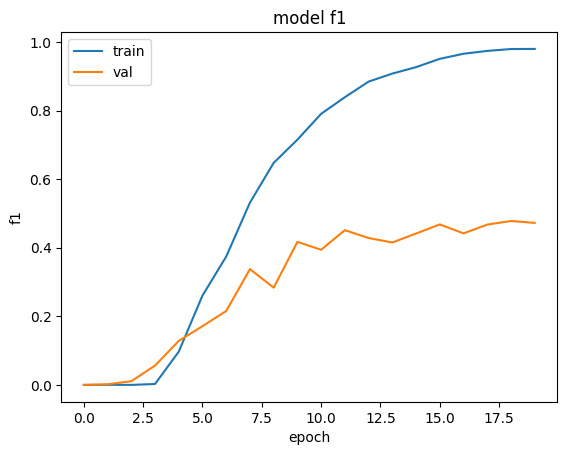

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 2) модель с 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense_1 (Dense)             (None, 19)                2451      
                                                                 
Total params: 806649 (3.08 MB)
Trainable params: 806649 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 8s 142ms/step - loss: 2.4938 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3217 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 5s 112ms/step - loss: 2.3123 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2971 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 3/20
43/43 [==============================] - 4s 94ms/step - loss: 2.2012 - f1: 8.4168e-04 - rec@prec: 3.7970e-04 - val_loss: 2.0026 - val_f1: 0.0623 - val_rec@prec: 0.0108
Epoch 4/20
43/43 [==============================] - 5s 110ms/step - loss: 1.8198 - f1: 0.0999 - rec@prec: 0.0522 - val_loss: 1.7061 - val_f1: 0.2123 - val_rec@prec: 0.1583
Epoch 5/20
43/43 [==============================] - 4s 98ms/step - loss: 1.5156 - f1: 0.3866 - rec@prec: 0.2084 - val_loss: 1.5967 - val_f1: 0.3521 - val_rec@prec: 0.2304
Epoch 6/20
43/43 [==============================] - 4s 87ms/step - loss: 1.4648 - f1: 0.4159 - rec@prec: 0

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


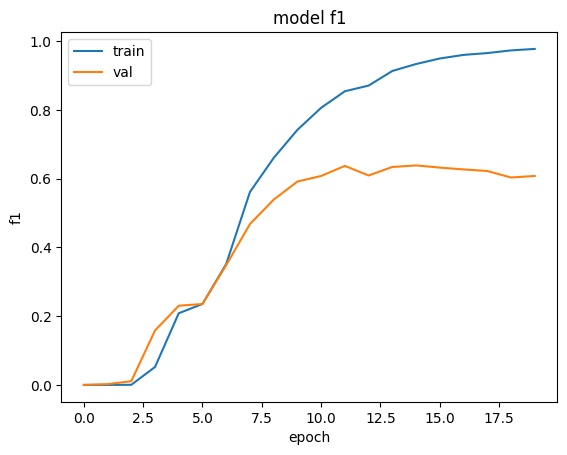

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 3) модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_1 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 19)                1235      
                                                                 
Total params: 912761 (3.48 MB)
Trainable params: 912761 (3.

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 40s 172ms/step - loss: 2.1123 - f1: 0.0342 - rec@prec: 0.0028 - val_loss: 1.7657 - val_f1: 0.0531 - val_rec@prec: 0.0302
Epoch 2/15
211/211 [==============================] - 23s 109ms/step - loss: 1.5015 - f1: 0.3143 - rec@prec: 0.1685 - val_loss: 1.3910 - val_f1: 0.4878 - val_rec@prec: 0.2804
Epoch 3/15
211/211 [==============================] - 18s 83ms/step - loss: 1.1087 - f1: 0.6254 - rec@prec: 0.4986 - val_loss: 1.1493 - val_f1: 0.6366 - val_rec@prec: 0.5316
Epoch 4/15
211/211 [==============================] - 15s 69ms/step - loss: 0.8092 - f1: 0.7533 - rec@prec: 0.7272 - val_loss: 1.0812 - val_f1: 0.6634 - val_rec@prec: 0.5564
Epoch 5/15
211/211 [==============================] - 13s 59ms/step - loss: 0.6258 - f1: 0.8146 - rec@prec: 0.8287 - val_loss: 1.1033 - val_f1: 0.6794 - val_rec@prec: 0.5789
Epoch 6/15
211/211 [==============================] - 10s 46ms/step - loss: 0.4981 - f1: 0.8542 - rec@prec: 0.8872 - val_loss: 1

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


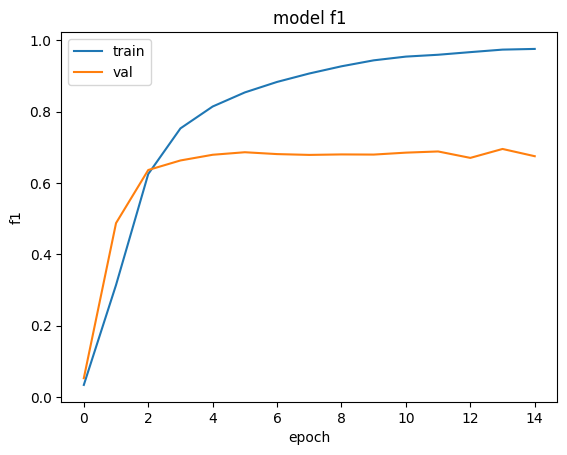

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 4) модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

bigru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True))(embeddings)

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 100)          2409300   
                                                                 
 bidirectional (Bidirection  (None, 200, 256)          176640    
 al)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          197120    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 19)                2451      
                                                           

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=10)

Epoch 1/10
211/211 [==============================] - 53s 202ms/step - loss: 2.0575 - f1: 0.0731 - rec@prec: 2.3732e-04 - val_loss: 1.6826 - val_f1: 0.1684 - val_rec@prec: 0.0203
Epoch 2/10
211/211 [==============================] - 31s 145ms/step - loss: 1.5212 - f1: 0.3530 - rec@prec: 0.0837 - val_loss: 1.3953 - val_f1: 0.5141 - val_rec@prec: 0.2759
Epoch 3/10
211/211 [==============================] - 24s 115ms/step - loss: 1.2315 - f1: 0.5831 - rec@prec: 0.3427 - val_loss: 1.2687 - val_f1: 0.5801 - val_rec@prec: 0.3756
Epoch 4/10
211/211 [==============================] - 21s 100ms/step - loss: 1.0808 - f1: 0.6464 - rec@prec: 0.4995 - val_loss: 1.1763 - val_f1: 0.6335 - val_rec@prec: 0.4567
Epoch 5/10
211/211 [==============================] - 21s 99ms/step - loss: 0.9492 - f1: 0.7038 - rec@prec: 0.6297 - val_loss: 1.1534 - val_f1: 0.6471 - val_rec@prec: 0.5185
Epoch 6/10
211/211 [==============================] - 19s 88ms/step - loss: 0.8150 - f1: 0.7585 - rec@prec: 0.7311 - val_l

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


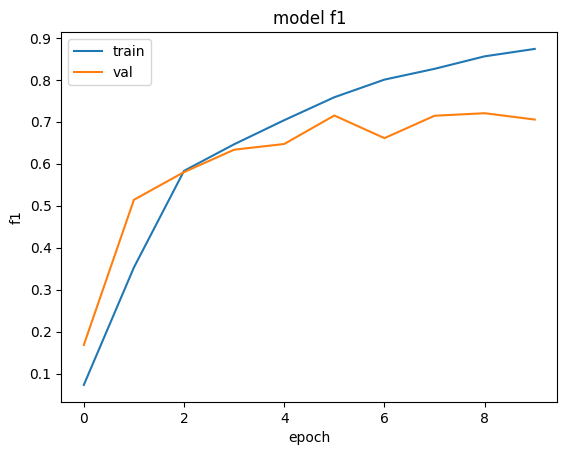

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 5) модель с 5 GRU слоями и 3 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 30)           722790    
                                                                 
 gru_3 (GRU)                 (None, 200, 128)          61440     
                                                                 
 gru_4 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_5 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_6 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_7 (GRU)                 (None, 200, 128)          9907

### 6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

bigru_forward = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=False))(embeddings)

bilstm_backward = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True))(embeddings)

hidden = tf.keras.layers.concatenate([bigru_forward, bilstm_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 200, 100)             2409300   ['input_6[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 256)                  176640    ['embedding_5[0][0]']         
 onal)                                                                                            
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 256)                  234496    ['embedding_5[0][0]']   

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=10)

Epoch 1/10
211/211 [==============================] - 36s 145ms/step - loss: 2.1980 - f1: 0.0046 - rec@prec: 2.1358e-04 - val_loss: 1.8711 - val_f1: 0.0333 - val_rec@prec: 0.0252
Epoch 2/10
211/211 [==============================] - 22s 105ms/step - loss: 1.6883 - f1: 0.2002 - rec@prec: 0.0538 - val_loss: 1.6683 - val_f1: 0.3390 - val_rec@prec: 0.1177
Epoch 3/10
211/211 [==============================] - 20s 94ms/step - loss: 1.3772 - f1: 0.5006 - rec@prec: 0.2284 - val_loss: 1.4002 - val_f1: 0.5123 - val_rec@prec: 0.3170
Epoch 4/10
211/211 [==============================] - 19s 91ms/step - loss: 1.1599 - f1: 0.6157 - rec@prec: 0.4340 - val_loss: 1.1717 - val_f1: 0.6186 - val_rec@prec: 0.4973
Epoch 5/10
211/211 [==============================] - 16s 75ms/step - loss: 0.9730 - f1: 0.6926 - rec@prec: 0.6117 - val_loss: 1.1478 - val_f1: 0.6711 - val_rec@prec: 0.5379
Epoch 6/10
211/211 [==============================] - 16s 78ms/step - loss: 0.8170 - f1: 0.7483 - rec@prec: 0.7202 - val_los

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


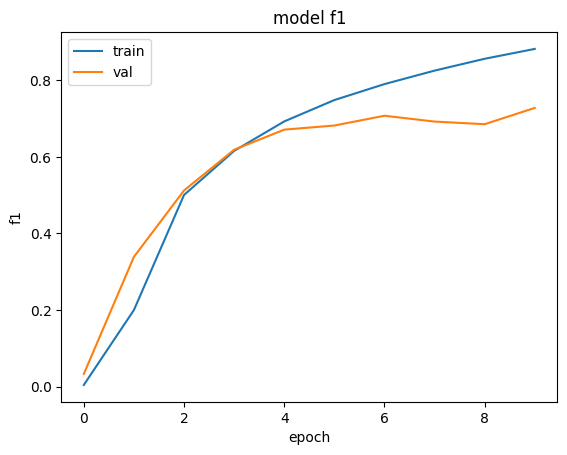

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)

bilstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=True))(gru_1)

bigru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True))(bilstm)

gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)

lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          2409300   
                                                                 
 lstm_8 (LSTM)               (None, 200, 128)          117248    
                                                                 
 gru_9 (GRU)                 (None, 200, 128)          99072     
                                                                 
 bidirectional_3 (Bidirecti  (None, 200, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 256)          296448    
 onal)                                                     

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=10)

Epoch 1/10
211/211 [==============================] - 54s 206ms/step - loss: 2.2526 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.0246 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
211/211 [==============================] - 38s 180ms/step - loss: 1.8707 - f1: 0.0955 - rec@prec: 0.0475 - val_loss: 1.7262 - val_f1: 0.1757 - val_rec@prec: 0.0857
Epoch 3/10
211/211 [==============================] - 35s 166ms/step - loss: 1.6689 - f1: 0.1854 - rec@prec: 0.1020 - val_loss: 1.8892 - val_f1: 0.2140 - val_rec@prec: 0.1353
Epoch 4/10
211/211 [==============================] - 34s 160ms/step - loss: 1.4341 - f1: 0.3602 - rec@prec: 0.1902 - val_loss: 1.3898 - val_f1: 0.4597 - val_rec@prec: 0.2430
Epoch 5/10
211/211 [==============================] - 33s 157ms/step - loss: 1.2048 - f1: 0.5823 - rec@prec: 0.3593 - val_loss: 1.1943 - val_f1: 0.6148 - val_rec@prec: 0.4509
Epoch 6/10
211/211 [==============================] - 33s 158ms/step - loss: 1.0413 - f1: 0.6677 - rec@prec: 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


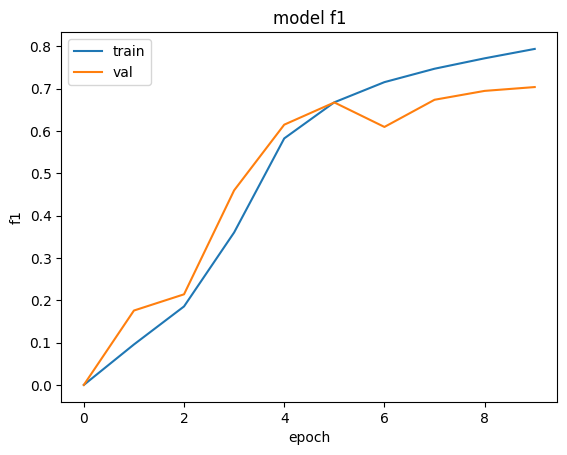

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Оцените качество каждой модели и определите победителя.
Последняя модель победила, показав лучшую F1 меру.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

### Предобработка с семинара

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("wikiann", 'ru')

In [ ]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

In [ ]:
dataset['train']['tokens'][1], dataset['train']['ner_tags'][1]

(["'", "''", 'Рыбницкий', 'район', "''", "'"], [0, 0, 5, 6, 0, 0])

In [ ]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

print(dict(list(vocab.items())[:10]))



{'илизаров': 1, ',': 9597, 'гавриил': 1, 'абрамович': 7, "'": 4470, "''": 5673, 'рыбницкий': 1, 'район': 118, 'за': 191, 'образцовое': 1}


In [ ]:
# тут словарь не очень большой и тут нужно предсказывать тэги для всех слов
# поэтому не будем фильтровать словарь
len(vocab)

36015

In [ ]:
# индексируем слова, каждому слову из словаря vocab (на основе трейна) присваивается уникальный индекс
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
# отображение индексов обратно на соответствующие слова
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
# переводим тексты из теста в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

# X – трейн
# X_test – тест
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [ ]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
print(X[:1])
print(X_test[:1])

print(y[:1])
print(y_test[:1])

[[2 3 4 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[   6    7 3587 3588    7    6    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[1 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
  7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]]
[[0 0 3 4 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
  7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]]


### Матрица с предобученными векторами

In [ ]:
# загружаем предобученную модель

import requests
import gzip
import shutil
import gensim

url = 'https://rusvectores.org/static/models/rusvectores4/araneum/araneum_upos_skipgram_300_2_2018.vec.gz'
filename = 'araneum_upos_skipgram_300_2_2018.vec.gz'

r = requests.get(url, stream=True)
with open(filename, 'wb') as f:
    shutil.copyfileobj(r.raw, f)

with gzip.open(filename, 'rb') as f_in:
    with open('araneum_upos_skipgram_300_2_2018.vec', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
rusvec_model = gensim.models.KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec', binary=False)


In [ ]:
rusvec_model.most_similar('изюм_NOUN')

[('курага_NOUN', 0.8573834300041199),
 ('чернослив_NOUN', 0.8140918016433716),
 ('сухофрукты_NOUN', 0.7855675220489502),
 ('цукат_NOUN', 0.7812947630882263),
 ('финик_NOUN', 0.7234672904014587),
 ('фундук_NOUN', 0.702560305595398),
 ('миндаль_NOUN', 0.7016867399215698),
 ('инжир_NOUN', 0.690302312374115),
 ('кунжут_NOUN', 0.687254011631012),
 ('кешью_NOUN', 0.6865500807762146)]

In [ ]:
# cлова в модели хранятся в нормализованном виде с прибавленной частью речи
# соответствие тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [ ]:
import requests
mapping_url = "https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map"
response = requests.get(mapping_url)
mapping = {}
for line in response.text.splitlines():
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [ ]:
from pymystem3 import Mystem
m = Mystem()

In [ ]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [ ]:
normalize_mystem('не очень-то, ! 34 PAD')

['не_PART', 'очень_ADV', 'то_PART', 'PAD_X']

In [ ]:
norm_word2id = {}
for word, idx in word2id.items():
    norm_words = normalize_mystem(word)
    if norm_words:  # проверяем, не пустой ли список нормализованных слов
        norm_word = norm_words[0]  # берем первое нормализованное слово
        if norm_word not in norm_word2id:  # проверяем, не было ли уже добавлено такое нормализованное слово
            norm_word2id[norm_word] = idx  # сохраняем индекс из изначального словаря
list(norm_word2id.items())[:10]

[('PAD_X', 0),
 ('UNK_X', 1),
 ('илизар_NOUN', 2),
 ('гавриил_NOUN', 4),
 ('абрамович_NOUN', 5),
 ('рыбницкий_ADJ', 8),
 ('район_NOUN', 9),
 ('за_ADP', 10),
 ('образцовый_ADJ', 11),
 ('выполнение_NOUN', 12)]

In [ ]:
list(word2id.items())[:15]

[('PAD', 0),
 ('UNK', 1),
 ('илизаров', 2),
 (',', 3),
 ('гавриил', 4),
 ('абрамович', 5),
 ("'", 6),
 ("''", 7),
 ('рыбницкий', 8),
 ('район', 9),
 ('за', 10),
 ('образцовое', 11),
 ('выполнение', 12),
 ('заданий', 13),
 ('командования', 14)]

In [ ]:
norm_id2word = {i:word for word, i in norm_word2id.items()}
list(norm_id2word.items())[:10]

[(0, 'PAD_X'),
 (1, 'UNK_X'),
 (2, 'илизар_NOUN'),
 (4, 'гавриил_NOUN'),
 (5, 'абрамович_NOUN'),
 (8, 'рыбницкий_ADJ'),
 (9, 'район_NOUN'),
 (10, 'за_ADP'),
 (11, 'образцовый_ADJ'),
 (12, 'выполнение_NOUN')]

In [ ]:
import numpy as np

embedding_dim = rusvec_model.vector_size
vocab_size = len(word2id)

# создаем матрицу с нулевыми эмбеддингами
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# счетчики для подсчета использованных векторов
found_in_rusvec = 0
random_vectors = 0

for idx, word in norm_id2word.items():
    if word == 'PAD':
        continue  # пропускаем слово с индексом 0 (паддинг)
    if word in rusvec_model:
        # если слово есть в предобученной модели, берем его вектор
        embedding_matrix[idx] = rusvec_model[word]
        found_in_rusvec += 1
    else:
        # если нет, генерируем случайный вектор
        embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
        random_vectors += 1

print("Найдено векторов в rusvec_model:", found_in_rusvec)
print("Сгенерировано случайных векторов:", random_vectors)

embedding_matrix.shape


Найдено векторов в rusvec_model: 12624
Сгенерировано случайных векторов: 12113


(36017, 300)

In [ ]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [ ]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

### 1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
# Используем нашу матрицу с векторами как веса для слоя еmbeddings
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, weights=[embedding_matrix], trainable=False)(inputs)

bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm_1)
bilstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm_3)

model_bilstm = tf.keras.Model(inputs=inputs, outputs=outputs)
model_bilstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_bilstm.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 54, 300)           10805100  
                                                                 
 bidirectional_18 (Bidirect  (None, 54, 256)           439296    
 ional)                                                          
                                                                 
 bidirectional_19 (Bidirect  (None, 54, 256)           394240    
 ional)                                                          
                                                                 
 bidirectional_20 (Bidirect  (None, 54, 256)           394240    
 ional)                                                          
                                                           

In [ ]:
model_bilstm.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 18s 53ms/step - loss: 0.1881 - accuracy: 0.9404 - val_loss: 0.1427 - val_accuracy: 0.9533
Epoch 2/5
157/157 [==============================] - 6s 39ms/step - loss: 0.1330 - accuracy: 0.9556 - val_loss: 0.1250 - val_accuracy: 0.9586
Epoch 3/5
157/157 [==============================] - 6s 39ms/step - loss: 0.1145 - accuracy: 0.9614 - val_loss: 0.1333 - val_accuracy: 0.9561
Epoch 4/5
157/157 [==============================] - 6s 39ms/step - loss: 0.0943 - accuracy: 0.9688 - val_loss: 0.1379 - val_accuracy: 0.9594
Epoch 5/5
157/157 [==============================] - 6s 39ms/step - loss: 0.0793 - accuracy: 0.9740 - val_loss: 0.1385 - val_accuracy: 0.9607


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


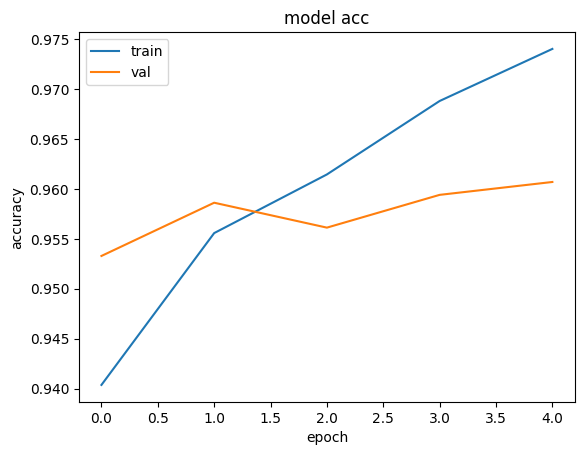

In [ ]:
print(model_bilstm.history.history.keys())
plt.plot(model_bilstm.history.history['accuracy'])
plt.plot(model_bilstm.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
# Используем нашу матрицу с векторами как веса для слоя еmbeddings
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, weights=[embedding_matrix], trainable=False)(inputs)

bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)
bigru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_3)

model_bigru = tf.keras.Model(inputs=inputs, outputs=outputs)
model_bigru.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_bigru.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 54, 300)           10805100  
                                                                 
 bidirectional_21 (Bidirect  (None, 54, 256)           330240    
 ional)                                                          
                                                                 
 bidirectional_22 (Bidirect  (None, 54, 256)           296448    
 ional)                                                          
                                                                 
 bidirectional_23 (Bidirect  (None, 54, 256)           296448    
 ional)                                                          
                                                           

In [ ]:
model_bigru.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 18s 45ms/step - loss: 0.1754 - accuracy: 0.9426 - val_loss: 0.1321 - val_accuracy: 0.9553
Epoch 2/5
157/157 [==============================] - 6s 37ms/step - loss: 0.1183 - accuracy: 0.9600 - val_loss: 0.1224 - val_accuracy: 0.9585
Epoch 3/5
157/157 [==============================] - 6s 37ms/step - loss: 0.0939 - accuracy: 0.9686 - val_loss: 0.1171 - val_accuracy: 0.9631
Epoch 4/5
157/157 [==============================] - 5s 33ms/step - loss: 0.0787 - accuracy: 0.9740 - val_loss: 0.1217 - val_accuracy: 0.9644
Epoch 5/5
157/157 [==============================] - 5s 35ms/step - loss: 0.0682 - accuracy: 0.9777 - val_loss: 0.1296 - val_accuracy: 0.9639


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


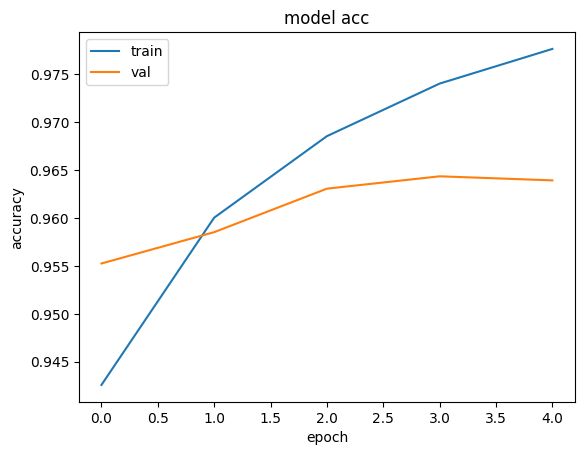

In [ ]:
print(model_bigru.history.history.keys())
plt.plot(model_bigru.history.history['accuracy'])
plt.plot(model_bigru.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
from sklearn.metrics import classification_report

#### Метрики model_bilstm

In [ ]:
pred_model_bilstm = model_bilstm.predict(X_test).argmax(2)

313/313 [==============================] - 6s 11ms/step


In [ ]:
pred_model_bilstm

array([[0, 0, 3, ..., 7, 7, 7],
       [0, 0, 6, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7],
       ...,
       [1, 2, 0, ..., 7, 7, 7],
       [5, 0, 0, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7]])

In [ ]:
print(classification_report(y_test.reshape(-1), pred_model_bilstm.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.79      0.94      0.86     40480
       B-PER       0.84      0.74      0.78      3542
       I-PER       0.85      0.80      0.83      7544
       B-ORG       0.68      0.14      0.23      4074
       I-ORG       0.68      0.32      0.44      8008
       B-LOC       0.42      0.60      0.49      4560
       I-LOC       0.56      0.38      0.45      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.73      0.61      0.64    540000
weighted avg       0.97      0.97      0.96    540000



In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [ ]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model_bilstm)

1/1 [==============================] - 0s 256ms/step


[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Светлане', 'O'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [ ]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model_bilstm)

1/1 [==============================] - 0s 131ms/step


[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-LOC'),
 ('в', 'O'),
 ('Питер', 'B-LOC')]

In [ ]:
label_seq('Встреча с Джоном Смитом запланирована на завтра в 15:00 в отеле "Метрополь"', word2id, id2labels, MAX_LEN, model_bilstm)

1/1 [==============================] - 0s 38ms/step


[('Встреча', 'O'),
 ('с', 'O'),
 ('Джоном', 'O'),
 ('Смитом', 'B-LOC'),
 ('запланирована', 'I-LOC'),
 ('на', 'O'),
 ('завтра', 'B-LOC'),
 ('в', 'O'),
 ('15', 'B-LOC'),
 (':', 'O'),
 ('00', 'O'),
 ('в', 'O'),
 ('отеле', 'O'),
 ('"', 'B-LOC'),
 ('Метрополь', 'I-LOC'),
 ('"', 'O')]

#### Метрики model_bigru

In [ ]:
pred_model_bigru = model_bigru.predict(X_test).argmax(2)

313/313 [==============================] - 6s 10ms/step


In [ ]:
pred_model_bigru

array([[0, 0, 3, ..., 7, 7, 7],
       [0, 0, 6, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7],
       ...,
       [1, 2, 0, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7],
       [0, 0, 0, ..., 7, 7, 7]])

In [ ]:
print(classification_report(y_test.reshape(-1), pred_model_bigru.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.74      0.99      0.85     40480
       B-PER       0.81      0.78      0.79      3542
       I-PER       0.86      0.80      0.83      7544
       B-ORG       0.79      0.21      0.33      4074
       I-ORG       0.88      0.24      0.38      8008
       B-LOC       0.65      0.40      0.50      4560
       I-LOC       0.80      0.27      0.41      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.82      0.59      0.64    540000
weighted avg       0.97      0.97      0.96    540000



In [ ]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model_bigru)

1/1 [==============================] - 0s 57ms/step


[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Светлане', 'O'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [ ]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model_bigru)

1/1 [==============================] - 0s 35ms/step


[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'O'),
 ('в', 'O'),
 ('Питер', 'B-LOC')]

In [ ]:
label_seq('Встреча с Джоном Смитом запланирована на завтра в 15:00 в отеле "Метрополь"', word2id, id2labels, MAX_LEN, model_bigru)

1/1 [==============================] - 3s 3s/step


[('Встреча', 'O'),
 ('с', 'O'),
 ('Джоном', 'O'),
 ('Смитом', 'B-LOC'),
 ('запланирована', 'O'),
 ('на', 'O'),
 ('завтра', 'B-LOC'),
 ('в', 'O'),
 ('15', 'B-LOC'),
 (':', 'O'),
 ('00', 'O'),
 ('в', 'O'),
 ('отеле', 'O'),
 ('"', 'B-PER'),
 ('Метрополь', 'I-LOC'),
 ('"', 'I-PER')]

Обе модели имеют высокие метрики для класса неименованных сущностей, видимо, потому что их больше. Персоналии (PER) предсказывают примерно одинаково (precision: 0.84 и 0.81, recall: 0.74 и 0.78 для model_bilstm и model_bigru соответственно), организации model_bigru показывает чуть лучше результаты (precision: 0.79 и 0.88, recall: 0.21 и 0.24 для model_bilstm и model_bigru соответственно), местоположения одинаково (precision: 0.42 и 0.65, recall: 0.60 и 0.40 для model_bilstm и model_bigru соответственно).

На конкретных примерах обе модели делают разные ошибки. Алексея обе правильно определеили, Москву и Санкт-Петербург тоже. Несколько раз несущности ошибочно принимались за сущность.